In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from scipy.sparse import spdiags
import codecs, json
import os
import subprocess



In [20]:
##GPU
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, csr_matrix
import subprocess
import torch
device = 'cuda' 

class GS():
    def __init__(self, N, filename):
        self.N = N
        self.u = torch.ones((N, N), dtype=torch.float64, device='cuda')
        self.v = torch.zeros((N, N), dtype=torch.float64, device='cuda')
        self.name = filename

    def initialize(self):
        N, N2, r = self.N, int(self.N / 2), 16
        self.u += 0.020 * torch.rand((N, N), device='cuda')
        self.v += 0.020 * torch.rand((N, N), device='cuda')
        self.u[N2 - r:N2 + r, N2 - r:N2 + r] = .5
        self.v[N2 - r:N2 + r, N2 - r:N2 + r] = .25
        return self.u, self.v

    def laplacian(self):
        N = self.N
        e = np.ones(N ** 2)
        e2 = ([1] * (N - 1) + [0]) * N
        e3 = ([0] + [1] * (N - 1)) * N
        A = spdiags([-4 * e, e2, e3, e, e], [0, -1, 1, -N, N], N ** 2, N ** 2)
        A = csr_matrix(A)
        A = self.scipy_to_torch_sparse(A)
        return A

    def scipy_to_torch_sparse(self, A):
        A = A.tocoo()
        indices = torch.from_numpy(np.vstack((A.row, A.col)).astype(np.int64)).cuda()
        values = torch.from_numpy(A.data).cuda()
        shape = torch.Size(A.shape)
        return torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float64, device='cuda')

    def integrate(self, iters, Du, Dv, F, K, L):
        u = self.u.view(-1)
        v = self.v.view(-1)

        Du = torch.tensor(Du, device='cuda', dtype=torch.float64)
        Dv = torch.tensor(Dv, device='cuda', dtype=torch.float64)
        F = torch.tensor(F, device='cuda', dtype=torch.float64)
        K = torch.tensor(K, device='cuda', dtype=torch.float64)

        
        for i in range(int(iters)):
            uvv = u * v * v
            u += (Du * torch.sparse.mm(L, u.unsqueeze(1)).squeeze() - uvv + F * (1 - u))
            v += (Dv * torch.sparse.mm(L, v.unsqueeze(1)).squeeze() + uvv - (F + K) * v)

            self.u = u
            self.v = v
    
        return
    
    def plot(self):
        u = self.u.cpu().numpy()
        v = self.v.cpu().numpy()

        f = plt.figure(figsize=(5,5), dpi=100, facecolor='w', edgecolor='None')
        sp = f.add_subplot(1, 1, 1)
        plt.pcolor(u.reshape((N, N)), cmap='viridis')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        #plt.savefig(f'{self.name}_{iteration:04d}.pdf', dpi=100)
        plt.show()



In [9]:
class GS():
    def __init__(self, N, filename, save_interval=1):
        self.N = N
        self.u = np.ones((N,N), dtype=np.float32)
        self.v = np.zeros((N,N), dtype=np.float32) 
        self.save_interval = save_interval 
        self.name = filename
    
    def initialize(self):
        N, N2, r = self.N, int(self.N/2), 16
        self.u += 0.02*np.random.random((N,N)).astype(np.float32)
        self.v += 0.020*np.random.random((N,N)).astype(np.float32)
        
        # Crear una distribución gaussiana centrada en el medio de la matriz
        x, y = np.meshgrid(np.linspace(0, N-1, N), np.linspace(0, N-1, N))
        pos = np.dstack((x, y))
        mean = [N2, N2]
        cov = [[r, 0], [0, r]]
        rv = multivariate_normal(mean, cov)

        gaussian_u = rv.pdf(pos)
        gaussian_v = rv.pdf(pos)

        # Normalizar las gaussianas para que los valores estén en el rango [0, 1]
        gaussian_u = gaussian_u / np.max(gaussian_u) * 0.5
        gaussian_v = gaussian_v / np.max(gaussian_v) * 0.35

        self.u += gaussian_u.astype(np.float32)
        self.v += gaussian_v.astype(np.float32)

        return self.u, self.v

    def laplacian(self):
        N = self.N
        e = np.ones(N**2)
        e2 = ([1]*(N-1)+[0])*N
        e3 = ([0]+[1]*(N-1))*N
        A = spdiags([-4*e, e2,e3,e,e],[0,-1,1,-N,N], N**2, N**2)

        return A
    
    def integrate(self,iters,Du,Dv,F,K,L):
        u = self.u.reshape((N*N))
        v = self.v.reshape((N*N))

        for i in range(int(iters)):
            uvv= u*v*v
            u+= (Du*L.dot(u) - uvv + F*(1-u))
            v+= (Dv*L.dot(v) + uvv - (F+K)*v)   
        
        self.u = u
        self.v = v

        return 
    
    def plot(self):
        u = self.u
        v = self.v

        f= plt.figure(figsize=(5,5),  facecolor='w', edgecolor='None')
        sp = f.add_subplot(1,1,1)
        plt.pcolor(u.reshape((N,N)),cmap='plasma')
        plt.xticks([]), plt.yticks([])
        plt.yticks([]), plt.xticks([])


        plt.axis('tight')
        plt.savefig(self.name+'.pdf',dpi=100)
        plt.show()

        return

In [2]:
# Diccionario de parámetros de reacción-difusión
rd_params = {
    'Bacteria 1': {'Du': 0.16, 'Dv': 0.08, 'F': 0.035, 'K': 0.065},
    'Bacteria 2': {'Du': 0.14, 'Dv': 0.06, 'F': 0.035, 'K': 0.065},
    'Coral': {'Du': 0.16, 'Dv': 0.08, 'F': 0.060, 'K': 0.0625},
    'Fingerprint': {'Du': 0.19, 'Dv': 0.05, 'F': 0.060, 'K': 0.0625},
    'Spirals': {'Du': 0.10, 'Dv': 0.10, 'F': 0.018, 'K': 0.050},
    'Spirals_Dense': {'Du': 0.12, 'Dv': 0.08, 'F': 0.020, 'K': 0.050},
    'Fast': {'Du': 0.10, 'Dv': 0.16, 'F': 0.020, 'K': 0.050},
    'Unstable': {'Du': 0.16, 'Dv': 0.08, 'F': 0.020, 'K': 0.055},
    'Worms_1': {'Du': 0.16, 'Dv': 0.08, 'F': 0.050, 'K': 0.065},
    'Worms_2': {'Du': 0.16, 'Dv': 0.08, 'F': 0.054, 'K': 0.063},
    'Zebrafish': {'Du': 0.16, 'Dv': 0.08, 'F': 0.035, 'K': 0.060},
    'Zebrafish_Spots': {'Du': 0.16, 'Dv': 0.08, 'F': 0.060, 'K': 0.0625}
}

In [4]:
def set_simulation_params(tipo):
    # Obtener los parámetros del tipo especificado
    params = rd_params.get(tipo)
        
    # Asignar los valores a las variables correspondientes
    filename = tipo.replace(' ', '_')
    Du = params['Du']
    Dv = params['Dv']
    F = params['F']
    K = params['K']
    
    return filename, Du, Dv, F, K

In [6]:
tipo = 'Zebrafish'
filename, Du, Dv, F, K = set_simulation_params(tipo)


0.035

In [7]:
def get_F(iteration):
    # Define the function that determines the value of F based on the iteration
    # You can use any mathematical expression or algorithm here
    return 0.035*np.cos(iteration)

# Update the value of F in the rd_params dictionary
rd_params['Zebrafish']['F'] = get_F

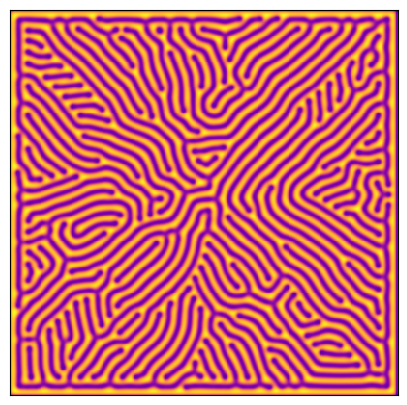

In [12]:
N = 400

iters = int(2*10**4)

GSsolver = GS(N, filename)

L = GSsolver.laplacian()

GSsolver.initialize()

GSsolver.integrate(iters,Du,Dv,F,K,L)
GSsolver.plot()

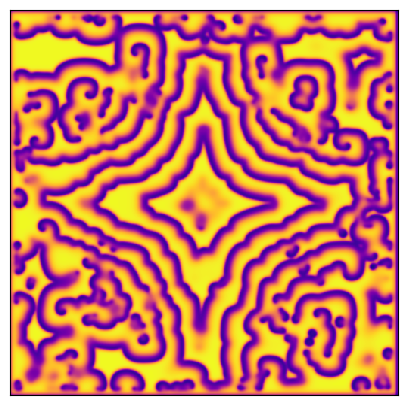

In [38]:

iters = int(2e4)

GSsolver = GS(N, filename)

L = GSsolver.laplacian()

GSsolver.initialize()

GSsolver.integrate(iters,Du,Dv,F,K,L)
GSsolver.plot()


In [14]:
2e4

20000.0

In [19]:

N = 400
iters = 2e4
save_interval = 100
t=10
GSsolver = GS(N, filename, save_interval, t)

L = GSsolver.laplacian()

GSsolver.initialize()

GSsolver.integrate(iters,Du,Dv,F,K,L)


Creando video con 200 fotogramas


: 

In [18]:
#CPU

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import subprocess

class GS():
    def __init__(self, N, filename, save_interval, t):
        self.N = N
        self.u = np.ones((N, N), dtype=np.float32)
        self.v = np.zeros((N, N), dtype=np.float32)
        self.name = filename
        self.save_interval = save_interval
        self.t = t

    def initialize(self):
        N, N2, r = self.N, int(self.N/2), 16
        self.u += 0.02*np.random.random((N,N)).astype(np.float32)
        self.v += 0.020*np.random.random((N,N)).astype(np.float32)
        
        # Crear una distribución gaussiana centrada en el medio de la matriz
        x, y = np.meshgrid(np.linspace(0, N-1, N), np.linspace(0, N-1, N))
        pos = np.dstack((x, y))
        mean = [N2, N2]
        cov = [[r, 0], [0, r]]
        rv = multivariate_normal(mean, cov)

        gaussian_u = rv.pdf(pos)
        gaussian_v = rv.pdf(pos)

        # Normalizar las gaussianas para que los valores estén en el rango [0, 1]
        gaussian_u = gaussian_u / np.max(gaussian_u) * 0.5
        gaussian_v = gaussian_v / np.max(gaussian_v) * 0.35

        self.u += gaussian_u.astype(np.float32)
        self.v += gaussian_v.astype(np.float32)

        return self.u, self.v

    def laplacian(self):
        N = self.N
        e = np.ones(N ** 2)
        e2 = ([1] * (N - 1) + [0]) * N
        e3 = ([0] + [1] * (N - 1)) * N
        A = spdiags([-4 * e, e2, e3, e, e], [0, -1, 1, -N, N], N ** 2, N ** 2)
        return A

    def integrate(self, iters, Du, Dv, F, K, L):
        u = self.u.reshape((self.N * self.N))
        v = self.v.reshape((self.N * self.N))

        
        frame_count = 0  # Contador de fotogramas
        for i in range(int(iters)):
            uvv = u * v * v
            u += (Du * L.dot(u) - uvv + F * (1 - u))
            v += (Dv * L.dot(v) + uvv - (F + K) * v)

            self.u = u
            self.v = v

            if i % self.save_interval == 0:
                self.plot(frame_count)  # Guardar imagen con un índice consecutivo
                frame_count += 1

        self.create_video(frame_count)  # Pasar el número total de frames al método de video
        self.cleanup_frames()

    def plot(self, frame_count):
        u = self.u

        f = plt.figure(figsize=(5, 5), edgecolor='None')
        sp = f.add_subplot(1, 1, 1)
        plt.pcolor(u.reshape((self.N, self.N)), cmap='rainbow')
        plt.axis('tight')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'frames/{self.name}_{frame_count:04d}.png')
        plt.close(f)

    def create_video(self, frame_count):
        # Crear el video usando las imágenes renombradas consecutivamente
        print(f"Creando video con {frame_count} fotogramas")
        command = [
            'ffmpeg', '-framerate', str((frame_count)/self.t), '-i', f'frames/{self.name}_%04d.png',
            '-c:v', 'libx264', '-pix_fmt', 'yuv420p',
            f'{self.name}_{self.N}_iters_{iters}_frames_{frame_count}.mp4'
        ]
        subprocess.run(command)

    def cleanup_frames(self):
        for file in os.listdir('frames'):
            os.remove(os.path.join('frames', file))

3.0

In [6]:
##GPU
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags, csr_matrix
import subprocess
import torch
device = 'cuda' 

class GS():
    def __init__(self, N, filename):
        self.N = N
        self.u = torch.ones((N, N), dtype=torch.float64, device='cuda')
        self.v = torch.zeros((N, N), dtype=torch.float64, device='cuda')
        self.name = filename

    def initialize(self):
        N, N2, r = self.N, int(self.N / 2), 16
        self.u += 0.020 * torch.rand((N, N), device='cuda')
        self.v += 0.020 * torch.rand((N, N), device='cuda')
        self.u[N2 - r:N2 + r, N2 - r:N2 + r] = .5
        self.v[N2 - r:N2 + r, N2 - r:N2 + r] = .25
        return self.u, self.v

    def laplacian(self):
        N = self.N
        e = np.ones(N ** 2)
        e2 = ([1] * (N - 1) + [0]) * N
        e3 = ([0] + [1] * (N - 1)) * N
        A = spdiags([-4 * e, e2, e3, e, e], [0, -1, 1, -N, N], N ** 2, N ** 2)
        A = csr_matrix(A)
        A = self.scipy_to_torch_sparse(A)
        return A

    def scipy_to_torch_sparse(self, A):
        A = A.tocoo()
        indices = torch.from_numpy(np.vstack((A.row, A.col)).astype(np.int64)).cuda()
        values = torch.from_numpy(A.data).cuda()
        shape = torch.Size(A.shape)
        return torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float64, device='cuda')

    def integrate(self, iters, Du, Dv, F, K, L):
        u = self.u.view(-1)
        v = self.v.view(-1)

        Du = torch.tensor(Du, device='cuda', dtype=torch.float64)
        Dv = torch.tensor(Dv, device='cuda', dtype=torch.float64)
        F = torch.tensor(F, device='cuda', dtype=torch.float64)
        K = torch.tensor(K, device='cuda', dtype=torch.float64)

        if not os.path.exists('frames'):
            os.makedirs('frames')

        for i in range(int(iters)):
            uvv = u * v * v
            u += (Du * torch.sparse.mm(L, u.unsqueeze(1)).squeeze() - uvv + F * (1 - u))
            v += (Dv * torch.sparse.mm(L, v.unsqueeze(1)).squeeze() + uvv - (F + K) * v)

            self.u = u
            self.v = v

            self.plot(i)

        self.create_video()
        self.cleanup_frames()

    def plot(self, iteration):
        u = self.u.cpu().numpy()
        v = self.v.cpu().numpy()

        f = plt.figure(figsize=(5,5), dpi=100, facecolor='w', edgecolor='None')
        sp = f.add_subplot(1, 1, 1)
        plt.pcolor(u.reshape((self.N, self.N)), cmap='viridis')
        plt.axis('tight')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'frames/{self.name}_{iteration:04d}.png', dpi=300)
        plt.close(f)

    def create_video(self):
        command = [
            'ffmpeg', '-framerate', '60', '-i', f'frames/{self.name}_%04d.png',
            '-c:v', 'libx264', '-pix_fmt', 'yuv420p', f'{self.name}_{N}_{iters}.mp4'
        ]
        subprocess.run(command)

    def cleanup_frames(self):
        for file in os.listdir('frames'):
            os.remove(os.path.join('frames', file))
        


In [3]:
import os
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse import spdiags, csr_matrix
import subprocess
N = 128
iters = 3542
filename = 'Fingerprint'

In [22]:
v_name=f'GS_N_{N}_t_{iters}.mp4'
save_interval = 2  
framerate = 1 / save_interval
os.system(f"ffmpeg '-framerate', {str(framerate)}, -i frames/{filename}_%4d.png -c:v libx264 -r 60 -pix_fmt yuv420p {v_name}")

-22